In [1]:
import tensorflow as tf
import labelbox as lb
from pprint import pprint
from API_key_personal import PERSONAL_API_KEY
from tqdm import tqdm
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

layers = tf.keras.layers
models = tf.keras.models


In [46]:
client = lb.Client(PERSONAL_API_KEY)

In [47]:
project = client.get_project("clqsva8cw1qk407wn7vpy9xn5")
IMG_SIZE = 128

In [48]:
export_params= {
  "attachments": False,
  "metadata_fields": False,
  "data_row_details": True,
  "project_details": True,
  "performance_details": True
}

export_task = project.export_v2(params=export_params)
export_task.wait_till_done()

if export_task.errors:
    print(export_task.errors)

export_json = export_task.result

In [49]:
pprint(export_json[0]["data_row"]["row_data"]) #Image
pprint(export_json[0]["projects"][project.uid]["labels"][0]["annotations"]["classifications"][0]["radio_answer"]["name"]) #label

'https://lb-mlse.s3.us-east-1.amazonaws.com/animals/image-6858'
'spider'


In [50]:
# Get class names
class_names = []
with open("./animal_names.txt", "r") as file:
    for animal_name in file:
        class_names.append(animal_name.strip())

print(class_names)

['dog', 'spider', 'chicken', 'horse', 'butterfly', 'cow', 'squirrel', 'sheep', 'cat', 'elephant']


In [52]:
# Separate data_rows in list
img_dict = {animal_name:[] for animal_name in class_names}


numpy_list = os.listdir("./numpy/")

for data_row in tqdm(export_json, total=25943):
    if not f'{data_row["data_row"]["global_key"]}.npy' in numpy_list:
        continue
    annotations = data_row["projects"][project.uid]["labels"]
    for annotation in annotations:
        classifications = annotation["annotations"]["classifications"]
        for classification in classifications:
            label = classification["radio_answer"]["name"]
            img = np.load(f'./numpy/{data_row["data_row"]["global_key"]}.npy')
            img = np.asarray(img, dtype=np.float32)/255
            img_dict[label].append(img)

25985it [2:50:12,  2.54it/s]                              


In [53]:
# Divide lists into train and test
train_labels = []
train_imgs = []

test_labels = []
test_imgs = []

#Percentage of image split
TRAIN_SPLIT = 0.8

for label, img_list in img_dict.items():
    split_index = int(TRAIN_SPLIT*len(img_list))
    for img in img_list[:split_index]:
        train_labels.append(label)
        train_imgs.append(img)
    for img in img_list[split_index:]:
        test_labels.append(label)
        test_imgs.append(img)

print(len(train_imgs), len(train_labels))
print(len(test_imgs), len(test_labels))
        

20710 20710
5183 5183


dog


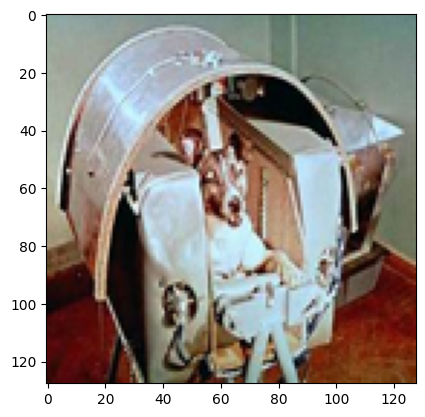

In [54]:
plt.imshow(test_imgs[80])
print(test_labels[80])

In [55]:
class_dict = {v:k for (k,v) in enumerate(class_names)}
train_labels = [class_dict[label] for label in train_labels]
test_labels = [class_dict[label] for label in test_labels]

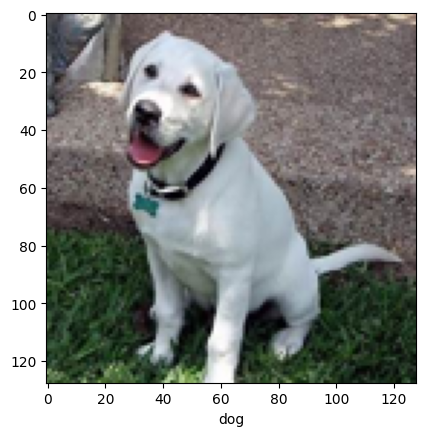

In [56]:
IMG_INDEX = 7
train_labels = np.array(train_labels)
train_labels = train_labels.reshape((-1,1))
plt.imshow(train_imgs[IMG_INDEX], cmap=plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()

In [57]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))

In [58]:

train_labels = np.array(train_labels)
train_labels = train_labels.reshape((-1,1))

test_labels = np.array(test_labels)
test_labels = test_labels.reshape((-1,1))

In [59]:
train_imgs = np.stack(train_imgs)
test_imgs = np.stack(test_imgs)

In [60]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(30))

In [61]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
history = model.fit(train_imgs, train_labels, epochs=10,
                    validation_data=(test_imgs, test_labels))

Epoch 1/10
648/648 [==============================] - 69s 105ms/step - loss: 1.7481 - accuracy: 0.3975 - val_loss: 1.4475 - val_accuracy: 0.5090
Epoch 2/10
648/648 [==============================] - 66s 102ms/step - loss: 1.2975 - accuracy: 0.5601 - val_loss: 1.3065 - val_accuracy: 0.5605
Epoch 3/10
648/648 [==============================] - 66s 102ms/step - loss: 1.0267 - accuracy: 0.6521 - val_loss: 1.3137 - val_accuracy: 0.5640
Epoch 4/10
648/648 [==============================] - 67s 103ms/step - loss: 0.7593 - accuracy: 0.7436 - val_loss: 1.2148 - val_accuracy: 0.6157
Epoch 5/10
648/648 [==============================] - 69s 106ms/step - loss: 0.5199 - accuracy: 0.8259 - val_loss: 1.3710 - val_accuracy: 0.6070
Epoch 6/10
648/648 [==============================] - 68s 105ms/step - loss: 0.3021 - accuracy: 0.8996 - val_loss: 1.8342 - val_accuracy: 0.5771
Epoch 7/10
648/648 [==============================] - 67s 103ms/step - loss: 0.1874 - accuracy: 0.9379 - val_loss: 2.1507 - val_ac

In [62]:
test_loss, test_acc = model.evaluate(test_imgs, test_labels, verbose=2)
print(test_acc)
print(test_imgs.shape)

162/162 - 4s - loss: 2.9395 - accuracy: 0.5786 - 4s/epoch - 27ms/step
0.5786224007606506
(5183, 128, 128, 3)


In [63]:
model.save(filepath="./models/Animal_ML_Model_V2.keras")